# Установка пакетов, догрузка необходимых файлов и функций


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import random
import seaborn as sns
import time
import xgboost
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
#Пути к файлам
Total_sample_path = '1. Sample creation/Total/'
tsne_path = '2. Model training and parameter estimation/t-SNE/'
Accuracy_path = '2. Model training and parameter estimation/Accuracy/'
Precision_path = '2. Model training and parameter estimation/Precision/'
Total_models_path = '2. Model training and parameter estimation/Total models/'
Matching_path = '2. Model training and parameter estimation/Matching/'

#Чтение файла с дескрипторами и выделение вектора
df_SAMPLE = pd.read_csv(Total_sample_path + 'df_SAMPLE.csv')
df_DESC = df_SAMPLE.copy()
del df_DESC['Sequence']
y = df_DESC['CPP'].values
del df_DESC['CPP']

#Часто используемые переменные
feature_names = np.array(df_DESC.columns)
final_desc = ['InstabilityInd', 
              '_ChargeD1025', '_ChargeD1075', '_ChargeD1100', 
              '_ChargeD3001', '_ChargeD3100',
              '_NormalizedVDWVD1001', '_NormalizedVDWVD2001',
              '_NormalizedVDWVD2025', '_NormalizedVDWVD2075',
              '_PolarityD1075', '_PolarityD3025',
              '_PolarizabilityD1100',
              '_SecondaryStrD2025', '_SecondaryStrD2075', '_SecondaryStrD2100',
              '_SecondaryStrD3025', '_SecondaryStrD3100',
              '_SolventAccessibilityD3025', '_SolventAccessibilityD3100']
model_name_short = ['KN_model', 'LR_model', 'XGB_model', 'RF_model', 'SVC_model']
model_name_full =  ['K-Nearest Neighbors', 'Logistic Regression', 'Gradient Boosting', 
                    'Random Forest', 'Support Vector']
model_name_rus =   ['K-ближайших соседей', 'Логистическая регрессия', 'Градиентный бустинг', 
                    'Случайный лес', 'Опорные вектора']
matching_models_name = ['K-ближайших соседей', 'Градиентный бустинг', 'Случайный лес',
                        'BChemRF-CPPred', 'C2Pred', 'MLCPP']
palette1 = ['#fcd07e', '#b3c0af', '#87a17e', '#cd9742', '#3f5837', '#cdaf7e']
palette2 = ['#3f5837', '#b3c0af', '#a16d36', '#87a17e', '#cd9742', '#fcd07e']
palette3 = ['#3f5837', '#87a17e', '#b3c0af', '#a16d36', '#cd9742', '#fcd07e']

In [ ]:
#Модели ACCURACY
KN_model_accuracy = joblib.load(Accuracy_path + 'KN_model_accuracy.pkl')
LR_model_accuracy = joblib.load(Accuracy_path + 'LR_model_accuracy.pkl')
XGB_model_accuracy = joblib.load(Accuracy_path + 'XGB_model_accuracy.pkl')
RF_model_accuracy = joblib.load(Accuracy_path + 'RF_model_accuracy.pkl')
SVC_model_accuracy = joblib.load(Accuracy_path + 'SVC_model_accuracy.pkl')

#Модели PRECISION
KN_model_precision = joblib.load(Precision_path + 'KN_model_precision.pkl')
LR_model_precision = joblib.load(Precision_path + 'LR_model_precision.pkl')
XGB_model_precision = joblib.load(Precision_path + 'XGB_model_precision.pkl')
RF_model_precision = joblib.load(Precision_path + 'RF_model_precision.pkl')
SVC_model_precision = joblib.load(Precision_path + 'SVC_model_precision.pkl')

#Выбранные модели
XGB_model_final = joblib.load(Total_models_path + 'XGB_model_final.pkl')
KN_model_final = joblib.load(Total_models_path + 'KN_model_final.pkl')
RF_model_final = joblib.load(Total_models_path + 'RF_model_final.pkl')

In [ ]:
#Создание словаря для записи метрик
def create_score_dict(dict_name, names):
    dict_name['Method'] = names
    dict_name['Accuracy'] = list()
    dict_name['F1'] = list()
    dict_name['Precision'] = list()
    dict_name['Recall'] = list()
    dict_name['ROC AUC'] = list()
    return dict_name

#Основные метрики
def calculate_metrics(model, x, y):
    pred = model.predict(x)
    a = accuracy_score(y, pred)
    f = f1_score(y, pred)
    p = precision_score(y, pred)
    r = recall_score(y, pred)
    pred = model.predict_proba(x)[:, 1]
    ra = roc_auc_score(y, pred)
    return a, f, p, r, ra

#Запись метрик в словарь
def write_in_score_dict(dict_name, a, f, p, r, ra):
    dict_name['Accuracy'].append('%.2f%%' % (np.array(a).mean() * 100.0))
    dict_name['F1'].append('%.2f%%' % (np.array(f).mean() * 100.0))
    dict_name['Precision'].append('%.2f%%' % (np.array(p).mean() * 100.0))
    dict_name['Recall'].append('%.2f%%' % (np.array(r).mean() * 100.0))
    dict_name['ROC AUC'].append('%.2f%%' % (np.array(ra).mean() * 100.0))
    return dict_name

#Быстрый запуск 
def quick_count(model, x, y, dict_name):
    accuracy, f1, precision, recall, roc_auc = calculate_metrics(model, x, y)
    dict_name = write_in_score_dict(dict_name, accuracy, f1, precision, recall, roc_auc)
    return dict_name

#Кросс-валидация
def cross_validation(k, x_train, y_train, model, dict_name):
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    ra, a, f, p, r = [], [], [], [], []
    for train_index, test_index in cv.split(x_train, y_train):
        X_train_, y_train_ = X_train[train_index], y_train[train_index]
        X_val, y_val = X_train[test_index], y_train[test_index]
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        a.append(accuracy_score(y_val, pred))
        f.append(f1_score(y_val, pred))
        p.append(precision_score(y_val, pred))
        r.append(recall_score(y_val, pred))
        pred = model.predict_proba(X_val)[:, 1]
        ra.append(roc_auc_score(y_val, pred))
    write_in_score_dict(dict_name, a, f, p, r, ra)
    return dict_name

#Дополнительные парметры для оценки моделей
def summary_parameters(models, names, X, y):
    summary_score = dict()
    summary_score = create_score_dict(summary_score, names)
    summary_score['ROC-curve'] = []
    summary_score['Predicted'] = []
    for model in models:
        summary_score = quick_count(model, X, y, summary_score)
        y_pred = model.predict_proba(X)[:,1]
        summary_score['ROC-curve'].append(roc_auc_score(y, y_pred))
        summary_score['Predicted'].append(y_pred)
    return summary_score

#Форматирование изображений
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style('white')
%matplotlib inline

# Уменьшение размерности

## PCA

In [ ]:
pca = PCA(n_components=10)
X_PCA = pca.fit_transform(df_DESC)

In [ ]:
pca = PCA(n_components=30)
X_pca = pca.fit_transform(df_DESC)
list_sum_pca = list()
sum_pca = 0
for i in range(30):
    sum_pca = sum_pca + pca.explained_variance_ratio_[i]
    list_sum_pca.append(sum_pca)

Text(0.3, 0.955, '0.98')

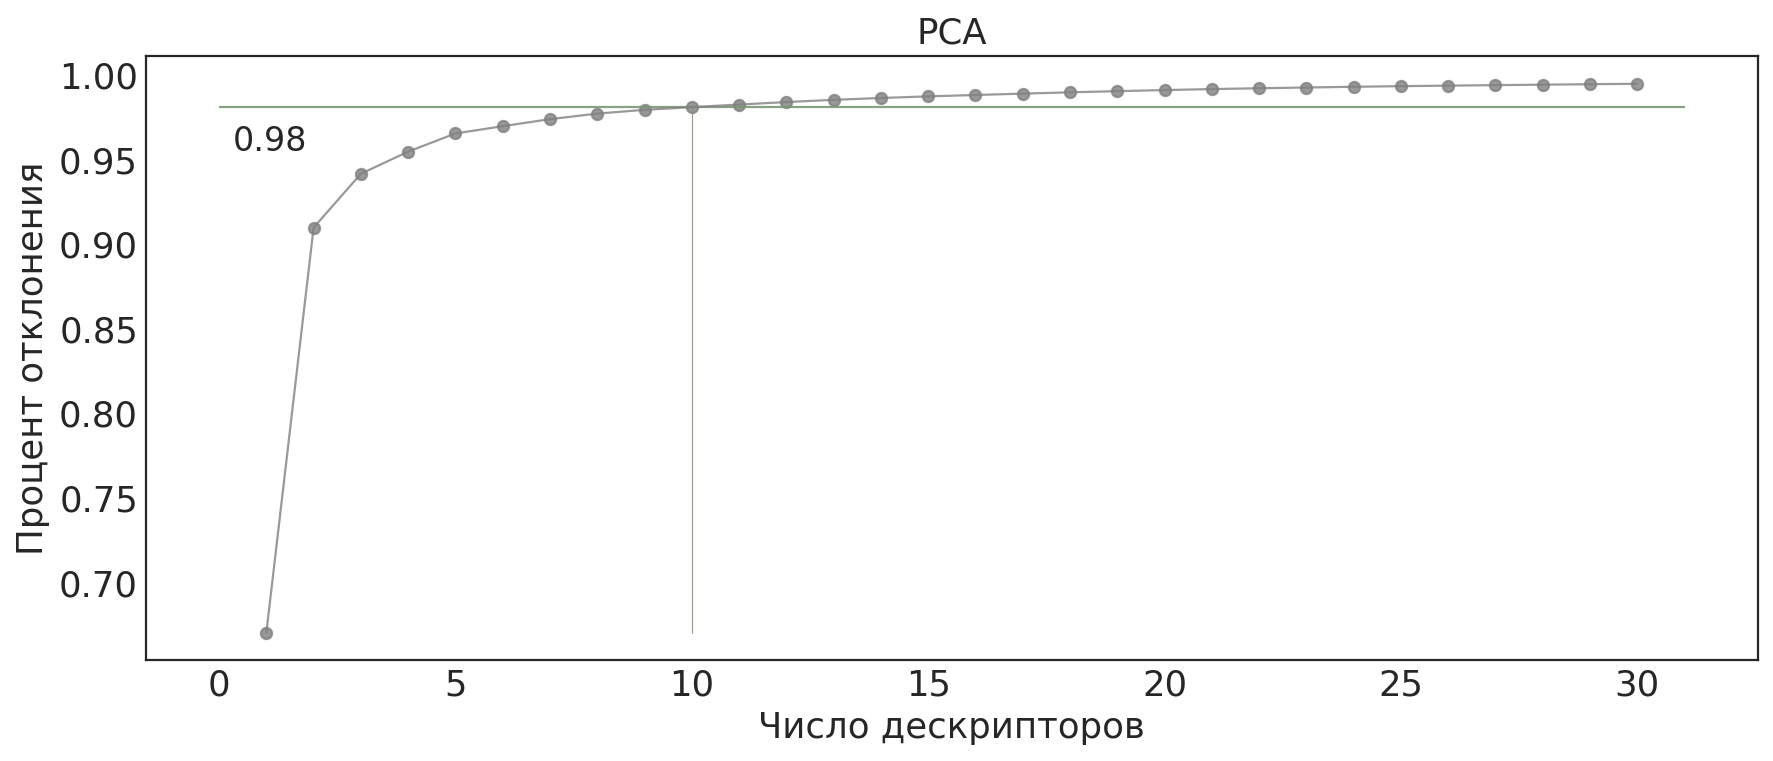

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), facecolor='white', dpi= 160)
ax.vlines(x=10, ymin=list_sum_pca[0], ymax=list_sum_pca[9], color='#7c9772', alpha=0.9, linewidth=0.5)
ax.scatter(x=list(range(1,31)), y=list_sum_pca, s=25, color='gray', alpha=0.8)
ax.hlines(y=list_sum_pca[9], xmin=0, xmax=31, color='#7c9772', alpha=0.9, linewidth=1, linestyles='solid')
plt.plot(list(range(1,31)), list_sum_pca, color='gray', lw=1, alpha=0.8)
ax.set_xlabel('Число дескрипторов')
ax.set_ylabel('Процент отклонения')
plt.title('PCA')
ax.text(0.3, 0.955, 0.98, fontsize = 15)

## t-SNE

In [ ]:
components = 5
tsne_file = tsne_path + 'tsne_' + str(components) + '.csv'
X_TSNE = pd.read_csv(tsne_file).to_numpy(dtype = 'float32')

In [ ]:
X_tsne_all = dict()
for t in range(1,31):
    tsne_file = tsne_path + 'tsne_' + str(t) + '.csv'
    X_tsne = pd.read_csv(tsne_file).to_numpy(dtype = 'float32')
    X_tsne_all[t] = X_tsne

In [ ]:
knn_score = list()
for i in range(1,31):
    X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test = train_test_split(X_tsne_all[i], y,
                                                                            train_size=0.85,
                                                                            shuffle = True,
                                                                            random_state = 40)
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_tsne_train, y_tsne_train)
    knn_score.append(knn.score(X_tsne_train, y_tsne_train))

Text(0.3, 0.9275, '0.93')

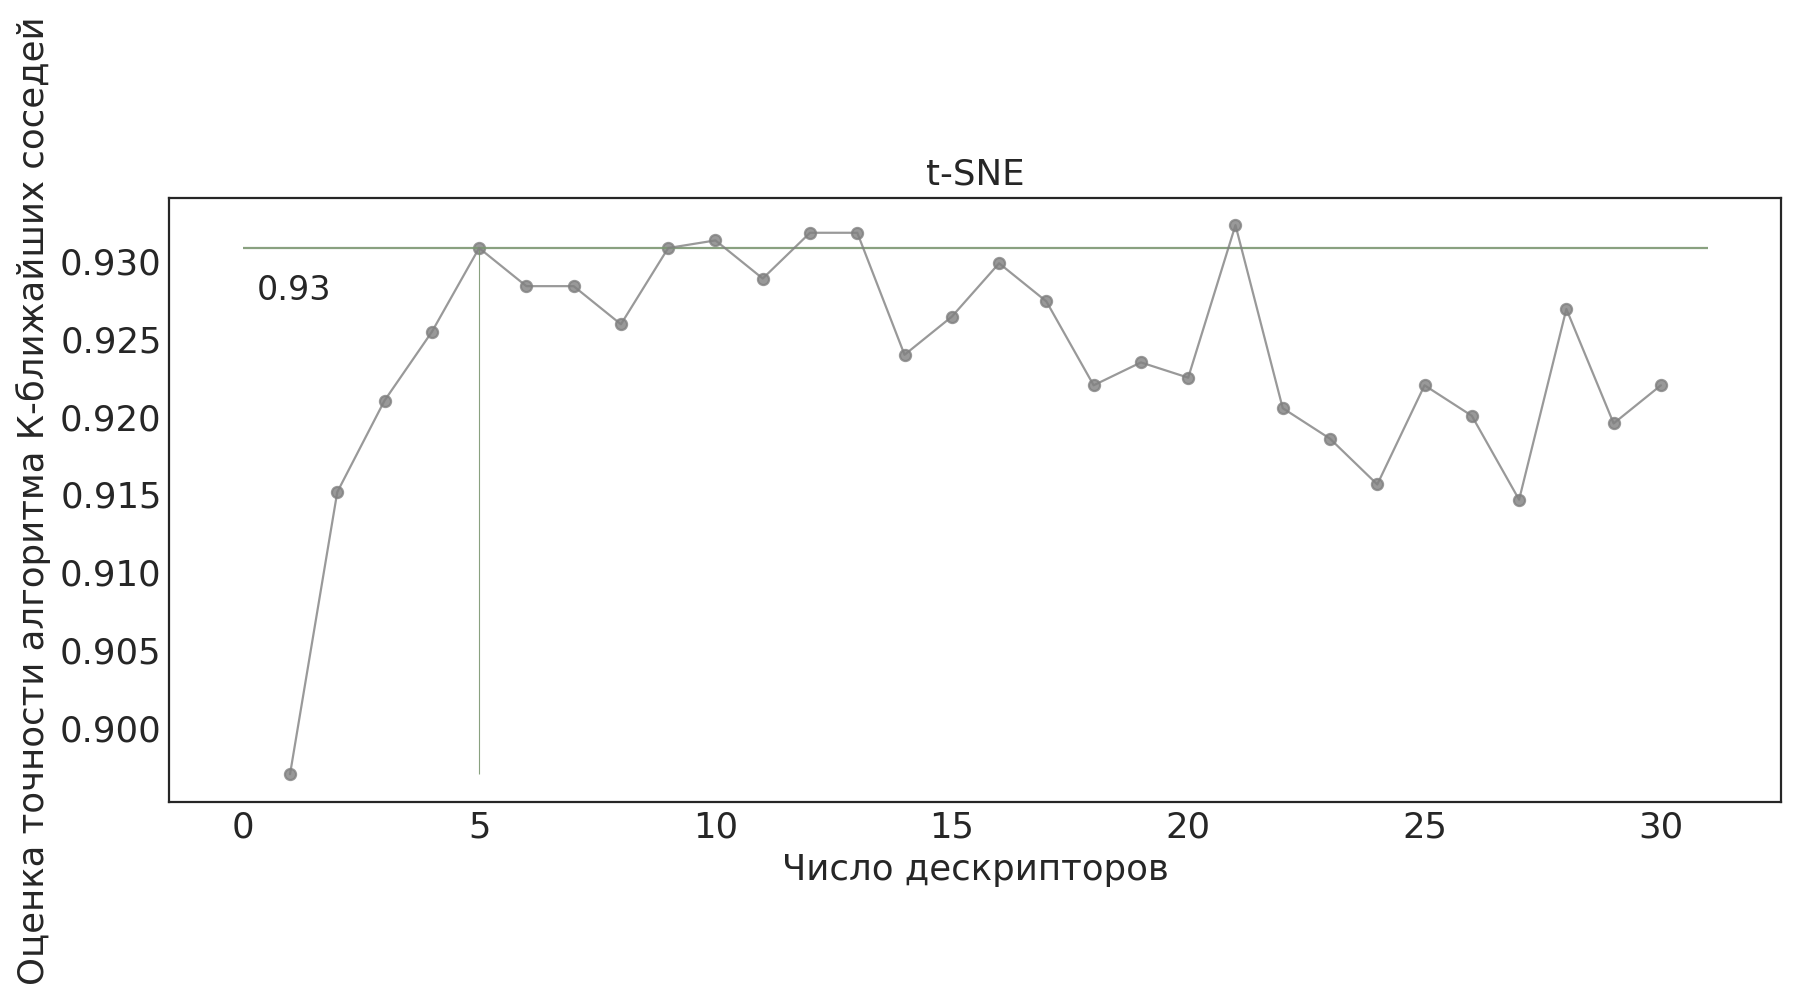

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), facecolor='white', dpi= 160)
ax.vlines(x=5, ymin=knn_score[0], ymax=knn_score[4], color='#7c9772', alpha=0.9, linewidth=0.5)
ax.scatter(x=list(range(1,31)), y=knn_score, s=25, color='gray', alpha=0.8)
ax.hlines(y=knn_score[4], xmin=0, xmax=31, color='#7c9772', alpha=0.9, linewidth=1, linestyles='solid')
plt.plot(list(range(1, 31, 1)), knn_score, color='gray', lw=1, alpha=0.8)
ax.set_xlabel('Число дескрипторов')
ax.set_ylabel('Оценка точности алгоритма К-ближайших соседей')
plt.title('t-SNE')
ax.text(0.3, 0.9275, 0.93, fontsize = 15)

## Lasso

In [ ]:
lasso = LassoCV().fit(df_DESC, y)
importance = np.abs(lasso.coef_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.050911707236139137, tolerance: 0.04461272158498413
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.051080095194919295, tolerance: 0.04461272158498413
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05399731944342534, tolerance: 0.04461272158498413
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might 

In [ ]:
not_null = dict()
for i in range(len(importance)):
    if importance[i] != 0:
        not_null[feature_names[i]] = [importance[i]]
        not_null[feature_names[i]].append(importance[i]/np.sum(importance))
sorted_tuples = sorted(not_null.items(), key=operator.itemgetter(1))
not_null_sorted = {k: v for k, v in reversed(sorted_tuples)}

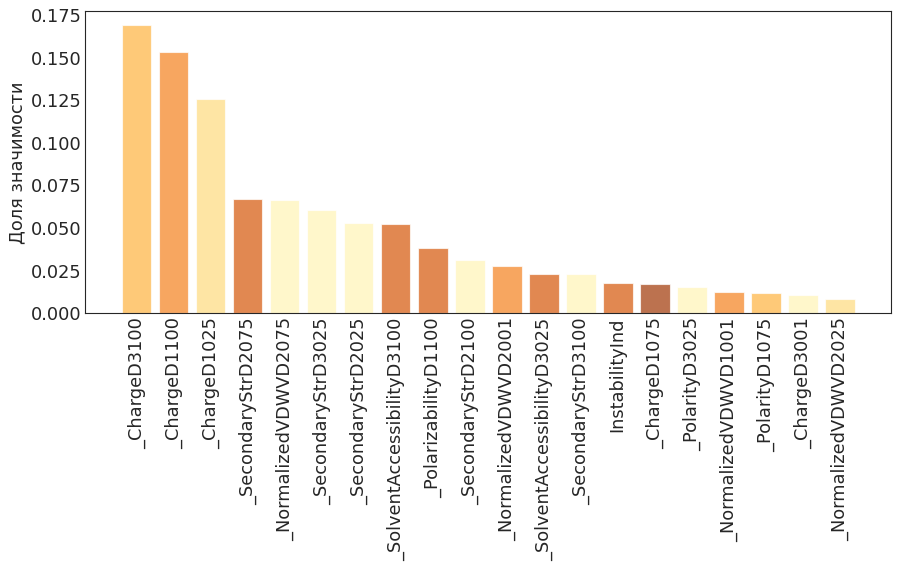

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), facecolor='white', dpi= 80)
for key in list(not_null_sorted)[:20]:
    plt.bar(height=not_null_sorted[key][1], x=key, color = random.choice(sns.color_palette('YlOrBr')), alpha = 0.7)
ax.set_ylabel('Доля значимости')
plt.xticks(rotation=90)
plt.show()

In [ ]:
sum = 0
names = list()
list_sum_not_null = list()
sum_not_null = dict()
for i, key in enumerate(not_null_sorted.keys()):
    sum += not_null_sorted[key][1]
    names.append(key)
    sum_not_null[i] = [sum]
    sum_not_null[i].append(names.copy())
    list_sum_not_null.append(sum)
df_LASSO = df_DESC[sum_not_null[16][1]].copy()

In [ ]:
#Нормализуем
scaler = StandardScaler()
df_LASSO = df_DESC[sum_not_null[19][1]].copy()
df_LASSO = scaler.fit_transform(df_LASSO)

Text(0.3, 0.91, '0.98')

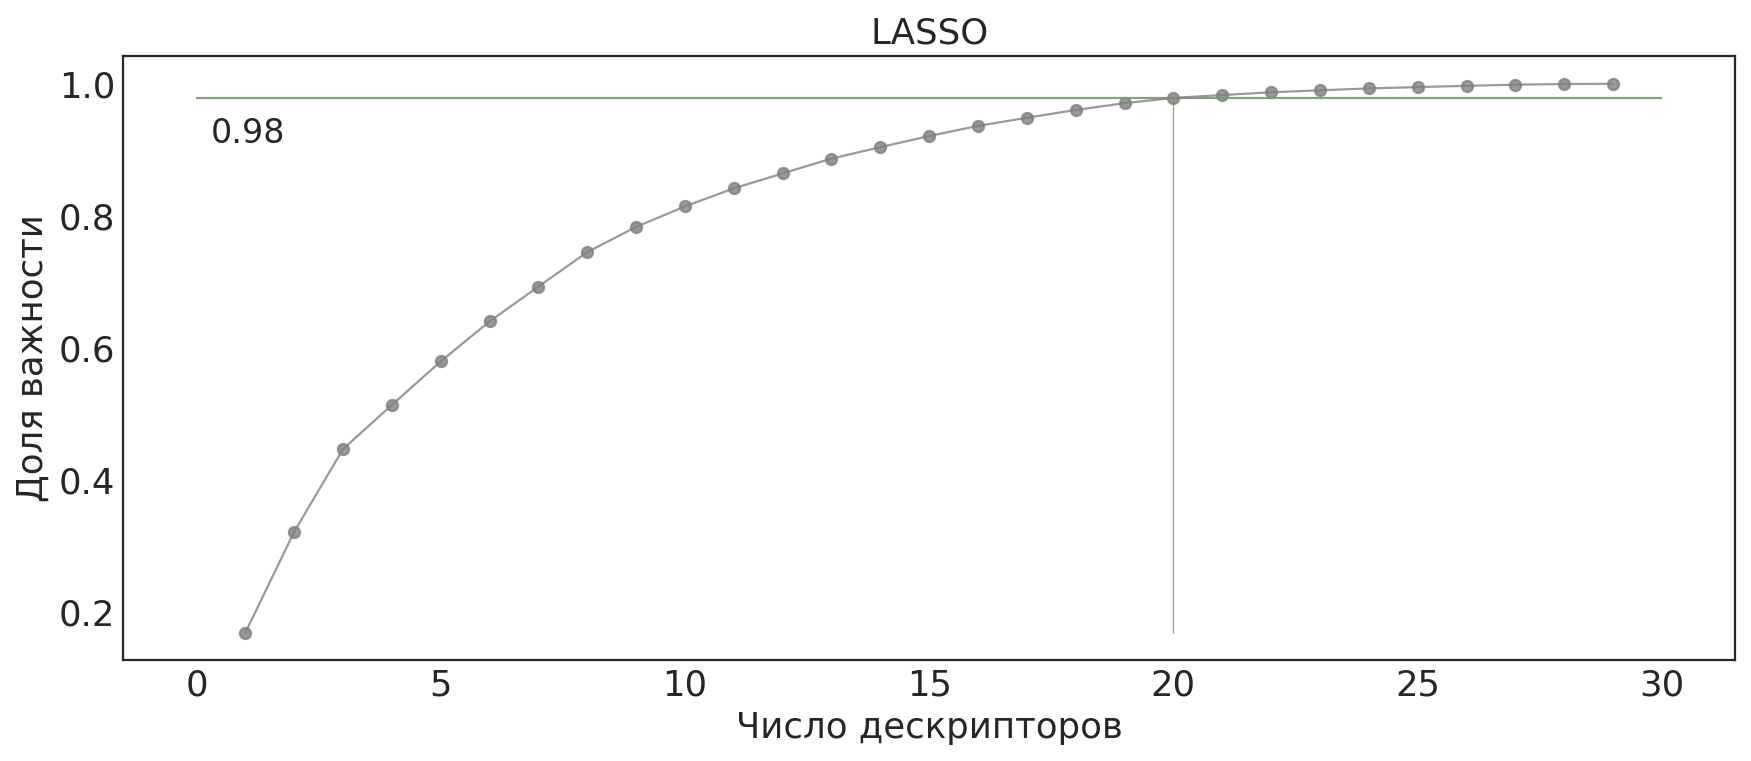

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), facecolor='white', dpi= 160)
ax.vlines(x=20, ymin=list_sum_not_null[0], ymax=list_sum_not_null[19], color='#7c9772', alpha=0.9, linewidth=0.5)
ax.scatter(x=list(range(1,30)), y=list_sum_not_null, s=25, color='gray', alpha=0.8)
ax.hlines(y=list_sum_not_null[19], xmin=0, xmax=30, color='#7c9772', alpha=0.9, linewidth=1, linestyles='solid')
plt.plot(list(range(1,30)), list_sum_not_null, color='gray', lw=1, alpha=0.8)
ax.set_xlabel('Число дескрипторов')
ax.set_ylabel('Доля важности')
plt.title('LASSO')
ax.text(0.3, 0.91, 0.98, fontsize = 15)

## Сравнение методов

In [ ]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_PCA, y,
                                                                    train_size=0.85,
                                                                    shuffle = True,
                                                                    random_state = 40)

In [ ]:
X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test = train_test_split(X_TSNE, y,
                                                                        train_size=0.85,
                                                                        shuffle = True,
                                                                        random_state = 40)

In [ ]:
X_lasso_train, X_lasso_test, y_lasso_train, y_lasso_test = train_test_split(df_LASSO, y,
                                                                            train_size=0.85,
                                                                            shuffle = True,
                                                                            random_state = 40)

In [ ]:
method_names = ['PCA', 't-SNE', 'LASSO']
test_train = [[X_pca_train, X_pca_test, y_pca_train, y_pca_test],
              [X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test],
              [X_lasso_train, X_lasso_test, y_lasso_train, y_lasso_test]]

### K-ближайших соседей

In [ ]:
score_knn = dict()
score_knn = create_score_dict(score_knn, method_names)

for i, tt in enumerate(test_train):
    knn = KNeighborsClassifier()
    knn.fit(tt[0], tt[2])
    accuracy, f1, precision, recall, roc_auc = calculate_metrics(knn, tt[1], tt[3])
    score_knn = write_in_score_dict(score_knn, accuracy, f1, precision, recall, roc_auc)

In [ ]:
print(pd.DataFrame(score_knn))

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA   80.56%  80.56%    80.56%  80.56%  88.32%
1  t-SNE   85.83%  85.39%    88.17%  82.78%  92.55%
2  LASSO   88.33%  88.20%    89.20%  87.22%  93.05%


### Логистическая регрессия

In [ ]:
score_logr = dict()
score_logr = create_score_dict(score_logr, method_names)

for tt in test_train:
    logr = LogisticRegression()
    logr.fit(tt[0], tt[2])
    accuracy, f1, precision, recall, roc_auc = calculate_metrics(logr, tt[1], tt[3])
    score_logr = write_in_score_dict(score_logr, accuracy, f1, precision, recall, roc_auc)

In [ ]:
print(pd.DataFrame(score_logr))

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA   81.39%  80.69%    83.83%  77.78%  89.09%
1  t-SNE   80.00%  80.54%    78.42%  82.78%  87.15%
2  LASSO   86.67%  86.59%    87.08%  86.11%  93.60%


### Градиентный бустинг

In [ ]:
score_xgb = dict()
score_xgb = create_score_dict(score_xgb, method_names)

for tt in test_train:
    xgb = xgboost.XGBClassifier()
    xgb.fit(tt[0], tt[2])
    accuracy, f1, precision, recall, roc_auc = calculate_metrics(xgb, tt[1], tt[3])
    score_xgb = write_in_score_dict(score_xgb, accuracy, f1, precision, recall, roc_auc)

In [ ]:
print(pd.DataFrame(score_xgb))

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA   85.56%  84.88%    89.02%  81.11%  92.37%
1  t-SNE   83.06%  82.11%    86.96%  77.78%  91.82%
2  LASSO   89.17%  88.89%    91.23%  86.67%  95.14%


### Случайный лес

In [ ]:
score_rf = dict()
score_rf = create_score_dict(score_rf, method_names)

for tt in test_train:
    rf = RandomForestClassifier()
    rf.fit(tt[0], tt[2])
    accuracy, f1, precision, recall, roc_auc = calculate_metrics(rf, tt[1], tt[3])
    score_rf = write_in_score_dict(score_rf, accuracy, f1, precision, recall, roc_auc)

In [ ]:
print(pd.DataFrame(score_rf))

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA   87.78%  87.21%    91.46%  83.33%  93.29%
1  t-SNE   84.72%  84.51%    85.71%  83.33%  92.15%
2  LASSO   89.17%  88.95%    90.75%  87.22%  96.29%


### Метод опорных векторов

In [ ]:
score_svc = dict()
score_svc = create_score_dict(score_svc, method_names)

for tt in test_train:
    svc = svm.SVC(probability = True)
    svc.fit(tt[0], tt[2])
    accuracy, f1, precision, recall, roc_auc = calculate_metrics(svc, tt[1], tt[3])
    score_svc = write_in_score_dict(score_svc, accuracy, f1, precision, recall, roc_auc)

In [ ]:
print(pd.DataFrame(score_svc))

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA   81.67%  81.03%    83.93%  78.33%  89.47%
1  t-SNE   85.28%  85.07%    86.29%  83.89%  91.90%
2  LASSO   88.61%  88.25%    91.12%  85.56%  94.71%


## Результаты

In [ ]:
print('\n K-Nearest Neighbors \n')
print(pd.DataFrame(score_knn))
print('\n Logistic Regression \n')
print(pd.DataFrame(score_logr))
print('\n Gradient Boosting \n')
print(pd.DataFrame(score_xgb))
print('\n Random Forest \n')
print(pd.DataFrame(score_rf))
print('\n Support Vector \n')
print(pd.DataFrame(score_svc))


 K-Nearest Neighbors 

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA   80.56%  80.56%    80.56%  80.56%  88.32%
1  t-SNE   85.83%  85.39%    88.17%  82.78%  92.55%
2  LASSO   88.33%  88.20%    89.20%  87.22%  93.05%

 Logistic Regression 

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA   81.39%  80.69%    83.83%  77.78%  89.09%
1  t-SNE   80.00%  80.54%    78.42%  82.78%  87.15%
2  LASSO   86.67%  86.59%    87.08%  86.11%  93.60%

 Gradient Boosting 

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA   85.56%  84.88%    89.02%  81.11%  92.37%
1  t-SNE   83.06%  82.11%    86.96%  77.78%  91.82%
2  LASSO   89.17%  88.89%    91.23%  86.67%  95.14%

 Random Forest 

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA   86.94%  86.22%    91.30%  81.67%  93.17%
1  t-SNE   84.17%  83.94%    85.14%  82.78%  92.68%
2  LASSO   89.17%  88.70%    92.73%  85.00%  95.80%

 Support Vector 

  Method Accuracy      F1 Precision  Recall ROC AUC
0    PCA 

# Выбор алгоритма

In [ ]:
#Нормализуем
scaler = StandardScaler()
df_FINAL = df_DESC[final_desc].copy()
df_FINAL = scaler.fit_transform(df_FINAL)

#Сегментируем
X_train, X_test, y_train, y_test = train_test_split(df_FINAL, y, 
                                                    train_size=0.85, 
                                                    shuffle = True,
                                                    random_state = 40)

## Модели с базовыми параметрами

### Отложенная выборка

In [ ]:
validation = dict()
validation = create_score_dict(validation, model_name_full)

In [ ]:
KN_model_val = KNeighborsClassifier()
KN_model_val.fit(X_train, y_train)
validation = quick_count(KN_model_val, X_test, y_test, validation)

In [ ]:
LR_model_val = LogisticRegression()
LR_model_val.fit(X_train, y_train)
validation = quick_count(LR_model_val, X_test, y_test, validation)

In [ ]:
XGB_model_val = xgboost.XGBClassifier()
XGB_model_val.fit(X_train, y_train)
validation = quick_count(XGB_model_val, X_test, y_test, validation)

In [ ]:
RF_model_val = RandomForestClassifier()
RF_model_val.fit(X_train, y_train)
validation = quick_count(RF_model_val, X_test, y_test, validation)

In [ ]:
SVC_model_val = svm.SVC(probability = True)
SVC_model_val.fit(X_train, y_train)
validation = quick_count(SVC_model_val, X_test, y_test, validation)

In [ ]:
pd.DataFrame(validation)

,Method,Accuracy,F1,Precision,Recall,ROC AUC
0,K-Nearest Neighbors,88.33%,88.20%,89.20%,87.22%,93.05%
1,Logistic Regression,86.67%,86.59%,87.08%,86.11%,93.60%
2,Gradient Boosting,89.17%,88.89%,91.23%,86.67%,95.14%
3,Random Forest,89.72%,89.46%,91.81%,87.22%,96.03%
4,Support Vector,88.61%,88.25%,91.12%,85.56%,94.71%


### Кроссвалидация

In [ ]:
KN_model_crv = KNeighborsClassifier()
LR_model_crv = LogisticRegression()
XGB_model_crv = xgboost.XGBClassifier()
RF_model_crv = RandomForestClassifier()
SVC_model_crv = svm.SVC(probability = True)

In [ ]:
crvalidation = dict()
crvalidation = create_score_dict(crvalidation, model_name_full)

In [ ]:
models_crv = [KN_model_crv, LR_model_crv, XGB_model_crv, RF_model_crv, SVC_model_crv]
for model in models_crv:
    crvalidation = cross_validation(10, X_train, y_train, model, crvalidation)

In [ ]:
pd.DataFrame(crvalidation)

,Method,Accuracy,F1,Precision,Recall,ROC AUC
0,K-Nearest Neighbors,86.80%,86.51%,87.32%,85.79%,92.38%
1,Logistic Regression,83.02%,82.42%,84.43%,80.62%,90.55%
2,Gradient Boosting,87.34%,86.85%,89.04%,84.89%,94.38%
3,Random Forest,87.34%,86.95%,88.81%,85.39%,94.61%
4,Support Vector,86.16%,85.49%,88.70%,82.61%,93.20%


## Подбор оптимальных гиперпараметров

In [ ]:
#ACCURACY
#KN_model_accuracy = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=18, weights='distance')
#LR_model_accuracy = LogisticRegression(C=0.1, max_iter=50, solver='liblinear')
#XGB_model_accuracy = xgboost.XGBClassifier(booster='gbtree', learning_rate=0.15, max_depth=8, n_estimators=100)
#RF_model_accuracy = RandomForestClassifier(criterion='entropy', max_features= 'sqrt', n_estimators=95)
#SVC_model_accuracy = svm.SVC(C=2, degree=2, gamma='auto', kernel='rbf', probability = True)

#PRECISION
#KN_model_precision = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=18, weights='uniform')
#LR_model_precision = LogisticRegression(C=0.1, max_iter=50, solver='liblinear')
#XGB_model_precision = xgboost.XGBClassifier(booster='gbtree', learning_rate=0.15, max_depth=8, n_estimators=100)
#RF_model_precision = RandomForestClassifier(criterion='entropy', max_features= 'auto', n_estimators=295)
#SVC_model_precision = svm.SVC(C=2, degree=4, gamma='auto', kernel='poly', probability = True)

### К-ближайших соседей

In [ ]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score)}
KN_grid_search = GridSearchCV(KNeighborsClassifier(n_jobs = -1), 
                               [{'n_neighbors': np.array(np.linspace(15, 20, 6), dtype='int'),
                                 'metric': ['minkowski', 'manhattan', 'euclidean', 'chebyshev'],
                                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                 'weights': ['uniform', 'distance']}],
                              scoring=scoring, 
                              #refit='Accuracy', 
                              refit='Precision',
                              return_train_score=True,
                              cv=10,
                              error_score=make_scorer(mean_squared_error),
                              verbose=10)

In [ ]:
#KN_grid_search.fit(df_FINAL, y)

In [ ]:
#ACCURACY
print(KN_grid_search.best_params_)
print(KN_grid_search.best_score_)
print(KN_grid_search.best_estimator_)

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
0.8414016736401673
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=18, p=2,
                     weights='distance')


In [ ]:
KN_model_accuracy = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=18, weights='distance')
KN_model_accuracy.fit(X_train, y_train)
KN_name_accuracy = Accuracy_path + 'KN_model_accuracy.pkl'
#joblib.dump(KN_model_accuracy, KN_name_accuracy)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Accuracy/KN_model_accuracy.pkl']

In [ ]:
#PRECISION
print(KN_grid_search.best_params_)
print(KN_grid_search.best_score_)
print(KN_grid_search.best_estimator_)

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'uniform'}
0.9029517075663895
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=18, p=2,
                     weights='uniform')


In [ ]:
KN_model_precision = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=18, weights='uniform')
KN_model_precision.fit(X_train, y_train)
KN_name_precision = Precision_path + 'KN_model_precision.pkl'
#joblib.dump(KN_model_precision, KN_name_precision)
KN_name_final = Total_models_path + 'KN_model_final.pkl'
#joblib.dump(KN_model_precision, KN_name_final)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Total models/KN_model_final.pkl']

### Логистическая регрессия

In [ ]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score)}
LR_grid_search = GridSearchCV(LogisticRegression(n_jobs = -1), 
                               [{'max_iter': np.array(np.linspace(50, 150, 6), dtype='int'),
                                 'solver': ['sag', 'saga', 'liblinear'],
                                 'C': [0.1, 1, 10]}],
                              scoring=scoring,
                              #refit='Accuracy', 
                              refit='Precision', 
                              return_train_score=True,
                              cv=10,
                              error_score=make_scorer(mean_squared_error),
                              verbose=10)

In [ ]:
#LR_grid_search.fit(df_FINAL, y)

In [ ]:
#ACCURACY
print(LR_grid_search.best_params_)
print(LR_grid_search.best_score_)
print(LR_grid_search.best_estimator_)

{'C': 0.1, 'max_iter': 50, 'solver': 'liblinear'}
0.8234588563458857
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
LR_model_accuracy = LogisticRegression(C=0.1, max_iter=50, solver='liblinear')
LR_model_accuracy.fit(X_train, y_train)
LR_name_accuracy = Accuracy_path + 'LR_model_accuracy.pkl'
#joblib.dump(LR_model_accuracy, LR_name_accuracy)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Accuracy/LR_model_accuracy.pkl']

In [ ]:
#PRECISION
print(LR_grid_search.best_params_)
print(LR_grid_search.best_score_)
print(LR_grid_search.best_estimator_)

{'C': 0.1, 'max_iter': 50, 'solver': 'liblinear'}
0.8418856668940494
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
LR_model_precision = LogisticRegression(C=0.1, max_iter=50, solver='liblinear')
LR_model_precision.fit(X_train, y_train)
LR_name_precision = Precision_path + 'LR_model_precision.pkl'
#joblib.dump(LR_model_precision, LR_name_precision)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Precision/LR_model_precision.pkl']

### Градиентный бустинг

In [ ]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score)}
GBR_grid_search = GridSearchCV(xgboost.XGBClassifier(n_jobs=-1), 
                               [{'learning_rate': np.array(np.linspace(0.01, 0.15, 4), dtype='float'),
                                 'n_estimators': np.array(np.linspace(50, 300, 6), dtype='int'),
                                 'max_depth': np.array(np.linspace(2, 10, 5), dtype='int'),
                                 'booster': ['gbtree', 'gblinear', 'dart']}],
                              scoring=scoring,
                              #refit='Accuracy', 
                              refit='Precision', 
                              return_train_score=True,
                              cv=10,
                              error_score=make_scorer(mean_squared_error),
                              verbose=10)

In [ ]:
#GBR_grid_search.fit(df_FINAL, y)

In [ ]:
#ACCURACY
print(GBR_grid_search.best_params_)
print(GBR_grid_search.best_score_)
print(GBR_grid_search.best_estimator_)

{'booster': 'gbtree', 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 100}
0.8832647857485328
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
XGB_model_accuracy = xgboost.XGBClassifier(booster='gbtree', learning_rate=0.15, max_depth=8, n_estimators=100)
XGB_model_accuracy.fit(X_train, y_train)
XGB_name_accuracy = Accuracy_path + 'XGB_model_accuracy.pkl'
#joblib.dump(XGB_model_accuracy, XGB_name_accuracy)
XGB_name_final = Total_models_path + 'XGB_model_final.pkl'
#joblib.dump(XGB_model_accuracy, XGB_name_final)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Total models/XGB_model_final.pkl']

In [ ]:
#PRECISION
print(GBR_grid_search.best_params_)
print(GBR_grid_search.best_score_)
print(GBR_grid_search.best_estimator_)

{'booster': 'gbtree', 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 100}
0.8832647857485328
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
XGB_model_precision = xgboost.XGBClassifier(booster='gbtree', learning_rate=0.15, max_depth=8, n_estimators=100)
XGB_model_precision.fit(X_train, y_train)
XGB_name_precision = Precision_path + 'XGB_model_precision.pkl'
#joblib.dump(XGB_model_precision, XGB_name_precision)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Precision/XGB_model_precision.pkl']

### Случайный лес

In [ ]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score)}
RF_grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1), 
                               [{'n_estimators': np.array(np.linspace(20, 320, 13), dtype='int'),
                                 'max_features': ['auto', 'sqrt', 'log2'],
                                 'criterion': ['gini', 'entropy']}],
                              scoring=scoring,
                              #refit='Accuracy', 
                              refit='Precision', 
                              return_train_score=True,
                              cv=10,
                              error_score=make_scorer(mean_squared_error),
                              verbose=10)

In [ ]:
#RF_grid_search.fit(df_FINAL, y)

In [ ]:
#ACCURACY
print(RF_grid_search.best_params_)
print(RF_grid_search.best_score_)
print(RF_grid_search.best_estimator_)

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 95}
0.8451900278940029
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [ ]:
RF_model_accuracy = RandomForestClassifier(criterion='entropy', max_features= 'sqrt', n_estimators=95)
RF_model_accuracy.fit(X_train, y_train)
RF_name_accuracy = Accuracy_path + 'RF_model_accuracy.pkl'
#joblib.dump(RF_model_accuracy, RF_name_accuracy)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Accuracy/RF_model_accuracy.pkl']

In [ ]:
#PRECISION
print(RF_grid_search.best_params_)
print(RF_grid_search.best_score_)
print(RF_grid_search.best_estimator_)

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 295}
0.8860181874626711
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=295,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [ ]:
RF_model_precision = RandomForestClassifier(criterion='entropy', max_features= 'auto', n_estimators=295)
RF_model_precision.fit(X_train, y_train)
RF_name_precision = Precision_path + 'RF_model_precision.pkl'
#joblib.dump(RF_model_precision, RF_name_precision)
RF_name_final = Total_models_path + 'RF_model_final.pkl'
joblib.dump(RF_model_precision, RF_name_final)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Total models/RF_model_final.pkl']

### Метод опорных векторов

In [ ]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score)}
SVC_grid_search = GridSearchCV(svm.SVC(probability = True), 
                               [{'degree': np.array(np.linspace(2, 4, 3), dtype='int'),
                                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                 'gamma': ['scale', 'auto'],
                                 'C': [2, 5, 7]}],
                              scoring=scoring,
                              refit='Accuracy', 
                              #refit='Precision', 
                              return_train_score=True,
                              cv=10,
                              error_score=make_scorer(mean_squared_error),
                              verbose=10)

In [ ]:
#SVC_grid_search.fit(df_FINAL, y)

In [ ]:
#ACCURACY
print(SVC_grid_search.best_params_)
print(SVC_grid_search.best_score_)
print(SVC_grid_search.best_estimator_)

{'C': 2, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
0.8293288005578802
SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [ ]:
SVC_model_accuracy = svm.SVC(C=2, degree=2, gamma='auto', kernel='rbf', probability = True)
SVC_model_accuracy.fit(X_train, y_train)
SVC_name_accuracy = Accuracy_path + 'SVC_model_accuracy.pkl'
#joblib.dump(SVC_model_accuracy, SVC_name_accuracy)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Accuracy/SVC_model_accuracy.pkl']

In [ ]:
#PRECISION
print(SVC_grid_search.best_params_)
print(SVC_grid_search.best_score_)
print(SVC_grid_search.best_estimator_)

{'C': 2, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}
0.8804305375576919
SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='auto', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [ ]:
SVC_model_precision = svm.SVC(C=2, degree=4, gamma='auto', kernel='poly', probability = True)
SVC_model_precision.fit(X_train, y_train)
SVC_name_precision = Precision_path + 'SVC_model_precision.pkl'
#joblib.dump(SVC_model_precision, SVC_name_precision)

['/content/drive/MyDrive/Algorithm/2. Model training and parameter estimation/Precision/SVC_model_precision.pkl']

## Оценка предсказательной способности

In [ ]:
models_accuracy = [KN_model_accuracy, LR_model_accuracy, XGB_model_accuracy, RF_model_accuracy, SVC_model_accuracy]
models_precision = [KN_model_precision, LR_model_precision, XGB_model_precision, RF_model_precision, SVC_model_precision]

In [ ]:
final_score_accuracy = pd.DataFrame(summary_parameters(models_accuracy, model_name_full, X_test, y_test))
final_score_accuracy

,Method,Accuracy,F1,Precision,Recall,ROC AUC,ROC-curve,Predicted
0,K-Nearest Neighbors,90.28%,89.86%,93.94%,86.11%,95.58%,0.955772,"[1.0, 0.05390419969956395, 0.6092619922953211,..."
1,Logistic Regression,86.94%,86.76%,88.00%,85.56%,93.56%,0.935648,"[0.7730434177065472, 0.4917832042152857, 0.483..."
2,Gradient Boosting,91.39%,91.22%,93.06%,89.44%,96.14%,0.961420,"[0.9751218, 0.011369676, 0.8723211, 0.99791425..."
3,Random Forest,89.72%,89.34%,92.81%,86.11%,95.80%,0.958040,"[0.9157894736842105, 0.15789473684210525, 0.50..."
4,Support Vector,89.17%,88.76%,92.22%,85.56%,95.05%,0.950494,"[0.8976476800782096, 0.14755633556780723, 0.77..."


In [ ]:
final_score_precision = pd.DataFrame(summary_parameters(models_precision, model_name_full, X_test, y_test))
final_score_precision

,Method,Accuracy,F1,Precision,Recall,ROC AUC,ROC-curve,Predicted
0,K-Nearest Neighbors,89.17%,88.43%,94.90%,82.78%,94.84%,0.948395,"[1.0, 0.05555555555555555, 0.5555555555555556,..."
1,Logistic Regression,86.94%,86.76%,88.00%,85.56%,93.56%,0.935648,"[0.7730434177065472, 0.4917832042152857, 0.483..."
2,Gradient Boosting,91.39%,91.22%,93.06%,89.44%,96.14%,0.961420,"[0.9751218, 0.011369676, 0.8723211, 0.99791425..."
3,Random Forest,89.72%,89.40%,92.31%,86.67%,96.40%,0.964043,"[0.8949152542372881, 0.13898305084745763, 0.56..."
4,Support Vector,84.72%,83.18%,92.52%,75.56%,92.46%,0.924552,"[0.8682881564866861, 0.19835342942940357, 0.76..."


## Проверка качества с помощью ROC-кривой

### Для моделей, обученных по accuracy

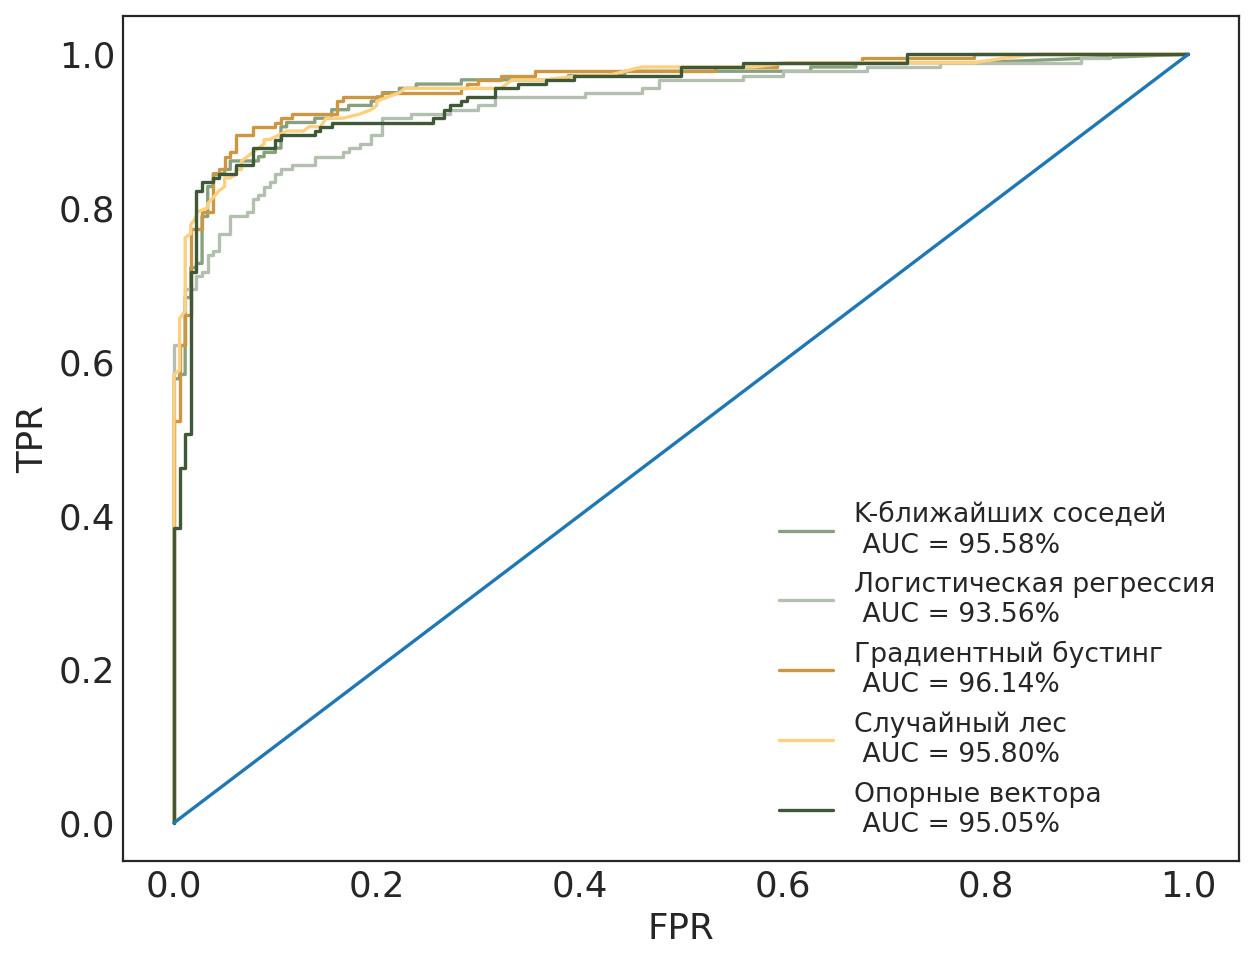

In [ ]:
plt.figure(figsize=(9,7), dpi= 160)
options = zip(model_name_rus, final_score_accuracy['Predicted'], final_score_accuracy['ROC-curve'], palette1)
for name, predict, rocauc, color in options:
    name = name + '\n AUC = %.2f%%'%(rocauc*100)
    plt.plot(*roc_curve(y_test, predict)[:2], label=name, color = color)
legend_box = plt.legend(fontsize=12, framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
#plt.title('Receiver operating characteristic curve', fontsize=20)
plt.xlabel('FPR', fontsize=16) 
plt.ylabel('TPR', fontsize=16)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

### Для моделей, обученных по precision

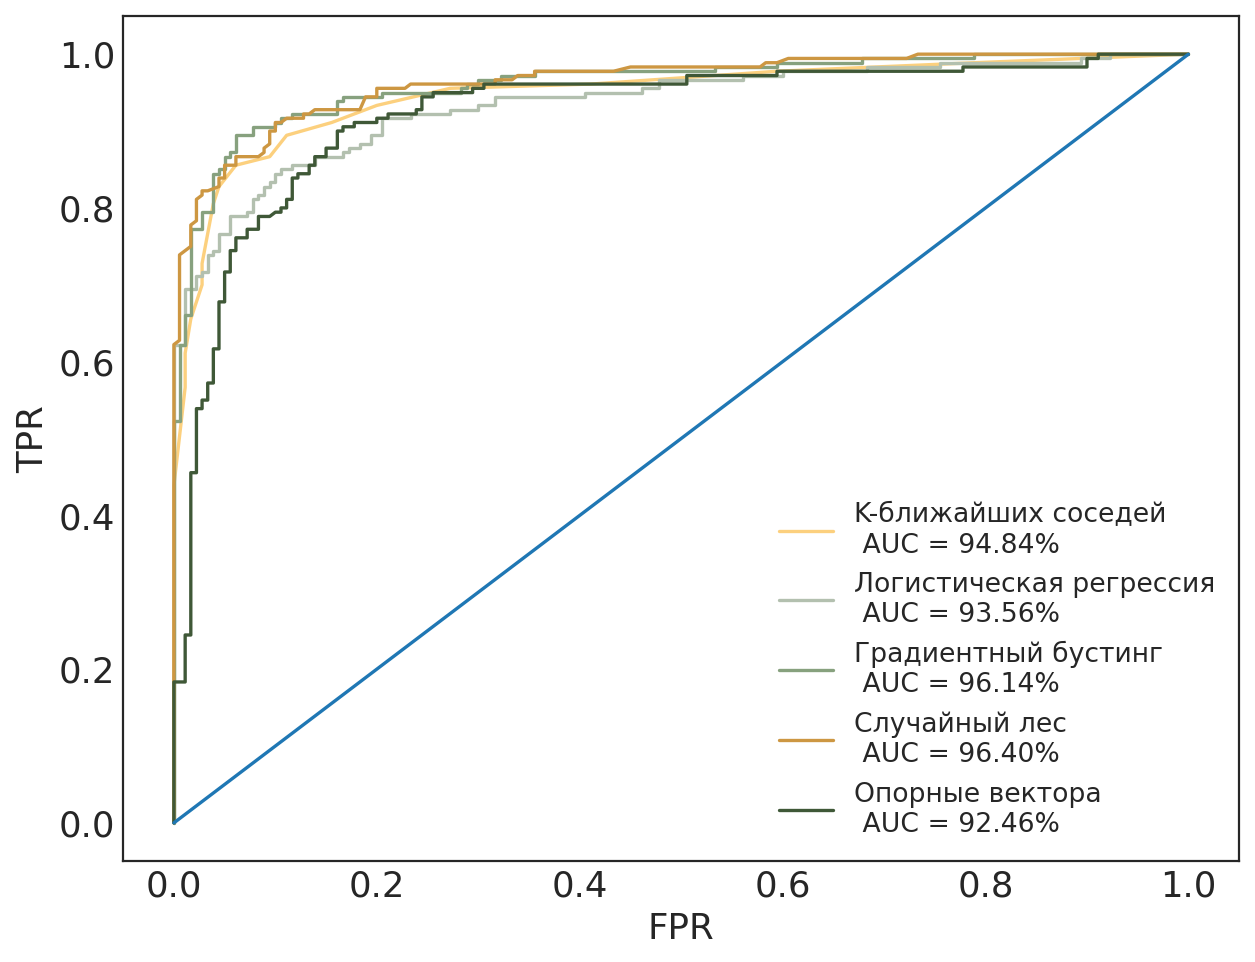

In [ ]:
plt.figure(figsize=(9,7), dpi= 160)
options = zip(model_name_rus, final_score_precision['Predicted'], final_score_precision['ROC-curve'], palette1)
for name, predict, rocauc, color in options:
    name = name + '\n AUC = %.2f%%'%(rocauc*100)
    plt.plot(*roc_curve(y_test, predict)[:2], label=name, color = color)
legend_box = plt.legend(fontsize=12, framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
#plt.title('Receiver operating characteristic curve', fontsize=20)
plt.xlabel('FPR', fontsize=16) 
plt.ylabel('TPR', fontsize=16)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## Проверка на переобучаемость

Таким образом, были выбраны три модели на основе их лучших характеристик: K-Nearest Neighbors, Gradient Boosting и Random Forest.

In [ ]:
def roc_auc_curve(model, x, y, y_pred, auc_score):
    y_test_pred = model.predict_proba(x)[:, 1]
    test_auc = roc_auc_score(y, y_test_pred)
    y_pred.append(y_test_pred)
    auc_score.append(test_auc)
    return y_pred, auc_score

In [ ]:
final_models = [KN_model_final, XGB_model_final, RF_model_final]
final_models_name = ['k-ближайших соседей \nОбучающая выборка', 'k-ближайших соседей \nТестовая выборка', 
                     'Градиентный бустинг \nОбучающая выборка', 'Градиентный бустинг \nТестовая выборка',
                     'Случайный лес \nОбучающая выборка', 'Случайный лес \nТестовая выборка']
y_test_train = [y_train, y_test, y_train, y_test, y_train, y_test]
y_predicted = list()
auc = list()
for model in final_models:
    y_predicted, auc = roc_auc_curve(model, X_train, y_train, y_predicted, auc)
    y_predicted, auc = roc_auc_curve(model, X_test, y_test, y_predicted, auc)

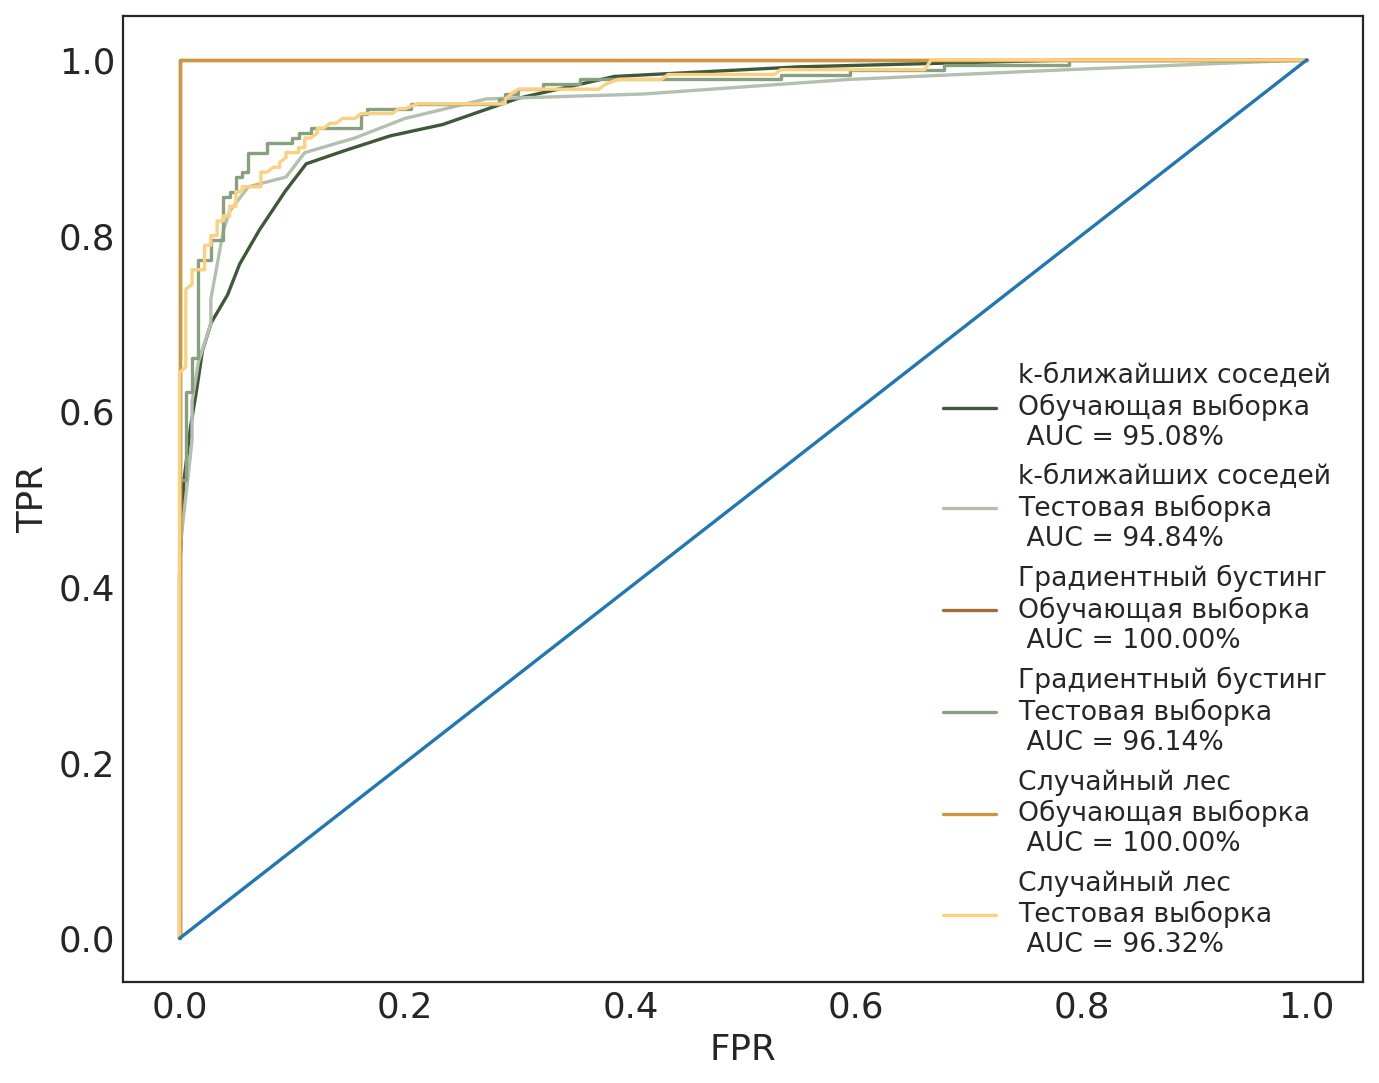

In [ ]:
plt.figure(figsize=(10,8), dpi= 160)
options = zip(final_models_name, y_predicted, auc, palette2, y_test_train)
for name, predict, rocauc, color, y_tt in options:
    name = name + '\n AUC = %.2f%%'%(rocauc*100)
    plt.plot(*roc_curve(y_tt, predict)[:2], label=name, color = color)
legend_box = plt.legend(fontsize=12, framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
#plt.title('Receiver operating characteristic curve', fontsize=20)
plt.xlabel('FPR', fontsize=16) 
plt.ylabel('TPR', fontsize=16)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

# Сравнение с существующими моделями

In [ ]:
#Из полного списка пептидов отсеиваем те, что находятся вне рамок диапазона в 5 - 30 ак
#Случайным образом получаем выборку из 1000 пептидов
df_SAMPLE = pd.read_csv(Total_sample_path + 'df_SAMPLE.csv')
CPP = list()
nCPP = list()
for index, row in df_SAMPLE.iterrows():
    if 5 <= len(row.Sequence) <= 35:
        if row.CPP:
            CPP.append(row.Sequence)
        else:
            nCPP.append(row.Sequence)
CPP_500 = random.sample(CPP, 500)
true = [True] * len(CPP_500)
nCPP_500 = random.sample(nCPP, 500)
false = [False] * len(nCPP_500)
sequence = CPP_500 + nCPP_500
cpp_flag = true + false
df_THOUSAND = pd.DataFrame({'CPP': cpp_flag, 'Sequence': sequence})
#df_THOUSAND.to_csv(Matching_path + 'df_THOUSAND.csv', index=False)
#with open(Matching_path + 'df_THOUSAND.fasta', 'w') as file:
#    for seq in sequence:
#      file.write('>' + seq + '\n')
#      file.write(seq + '\n')

In [ ]:
df_THOUSAND = pd.read_csv(Matching_path + 'df_THOUSAND.csv')
sequence = list(df_THOUSAND.Sequence)
df_MATCHING = df_SAMPLE.copy()
df_MATCHING = df_MATCHING[df_MATCHING.Sequence.isin(sequence)]
y_matching = df_MATCHING.CPP
df_MATCHING = df_MATCHING[final_desc].copy()
scaler = StandardScaler()
df_MATCHING = scaler.fit_transform(df_MATCHING)

In [ ]:
matching = dict()
matching = create_score_dict(matching, matching_models_name)
matching = quick_count(KN_model_final, df_MATCHING, y_matching, matching)
matching = quick_count(XGB_model_final, df_MATCHING, y_matching, matching)
matching = quick_count(RF_model_final, df_MATCHING, y_matching, matching)

## BChemRF-CPPred

In [ ]:
CPPred = pd.read_csv(Matching_path + 'BChemRF-CPPred.csv')
pred_CPPred = list()
pred_CPPred_probability = list()
for index, row in CPPred.iterrows():
    seq = row['Classification']
    if seq == 'CPP':
        pred_CPPred.append(True)
        prob = float(row['Probability'][:-1])*0.01
        pred_CPPred_probability.append(prob)
    else:
        pred_CPPred.append(False)
        prob = 1 - float(row['Probability'][:-1])*0.01
        pred_CPPred_probability.append(prob)

In [ ]:
accuracy = accuracy_score(y_matching, pred_CPPred)
f1 = f1_score(y_matching, pred_CPPred)
precision = precision_score(y_matching, pred_CPPred)
recall = recall_score(y_matching, pred_CPPred)
roc_auc = roc_auc_score(y_matching, pred_CPPred_probability)
matching = write_in_score_dict(matching, accuracy, f1, precision, recall, roc_auc)

## C2Pred

In [ ]:
C2Pred = pd.read_excel(Matching_path + 'C2Pred.xlsx')
pred_C2Pred = list()
pred_C2Pred_probability = list()
for index, row in C2Pred.iterrows():
    seq = row[C2Pred.columns[0]].strip().split()[0]
    prob = row[C2Pred.columns[0]].strip().split()[1]
    if seq == 'CPP':
        pred_C2Pred.append(True)
        pred_C2Pred_probability.append(float(prob))
    else:
        pred_C2Pred.append(False)
        pred_C2Pred_probability.append(float(prob))

In [ ]:
accuracy = accuracy_score(y_matching, pred_C2Pred)
f1 = f1_score(y_matching, pred_C2Pred)
precision = precision_score(y_matching, pred_C2Pred)
recall = recall_score(y_matching, pred_C2Pred)
roc_auc = roc_auc_score(y_matching, pred_C2Pred_probability)
matching = write_in_score_dict(matching, accuracy, f1, precision, recall, roc_auc)

## MLCPP

In [ ]:
MLCPP = pd.read_excel(Matching_path + 'MLCPP.xlsx')
pred_MLCPP = list()
pred_MLCPP_probability = list()
for index, row in MLCPP.iterrows():
    seq = row['Cell-penetrating or not'].strip().split()[0]
    prob = float(row['Probability score'])
    if seq == 'CPP':
        pred_MLCPP.append(True)
        pred_MLCPP_probability.append(prob)
    else:
        pred_MLCPP.append(False)
        pred_MLCPP_probability.append(prob)

In [ ]:
accuracy = accuracy_score(y_matching, pred_MLCPP)
f1 = f1_score(y_matching, pred_MLCPP)
precision = precision_score(y_matching, pred_MLCPP)
recall = recall_score(y_matching, pred_MLCPP)
roc_auc = roc_auc_score(y_matching, pred_MLCPP_probability)
matching = write_in_score_dict(matching, accuracy, f1, precision, recall, roc_auc)

## Результаты

In [ ]:
pd.DataFrame(matching)

,Method,Accuracy,F1,Precision,Recall,ROC AUC
0,K-ближайших соседей,87.30%,86.45%,92.68%,81.00%,94.94%
1,Градиентный бустинг,98.30%,98.29%,98.79%,97.80%,99.73%
2,Случайный лес,98.00%,97.98%,98.78%,97.20%,99.79%
3,BChemRF-CPPred,86.30%,85.06%,93.53%,78.00%,93.17%
4,C2Pred,83.80%,84.36%,81.53%,87.40%,91.00%
5,MLCPP,92.90%,93.09%,90.70%,95.60%,98.53%


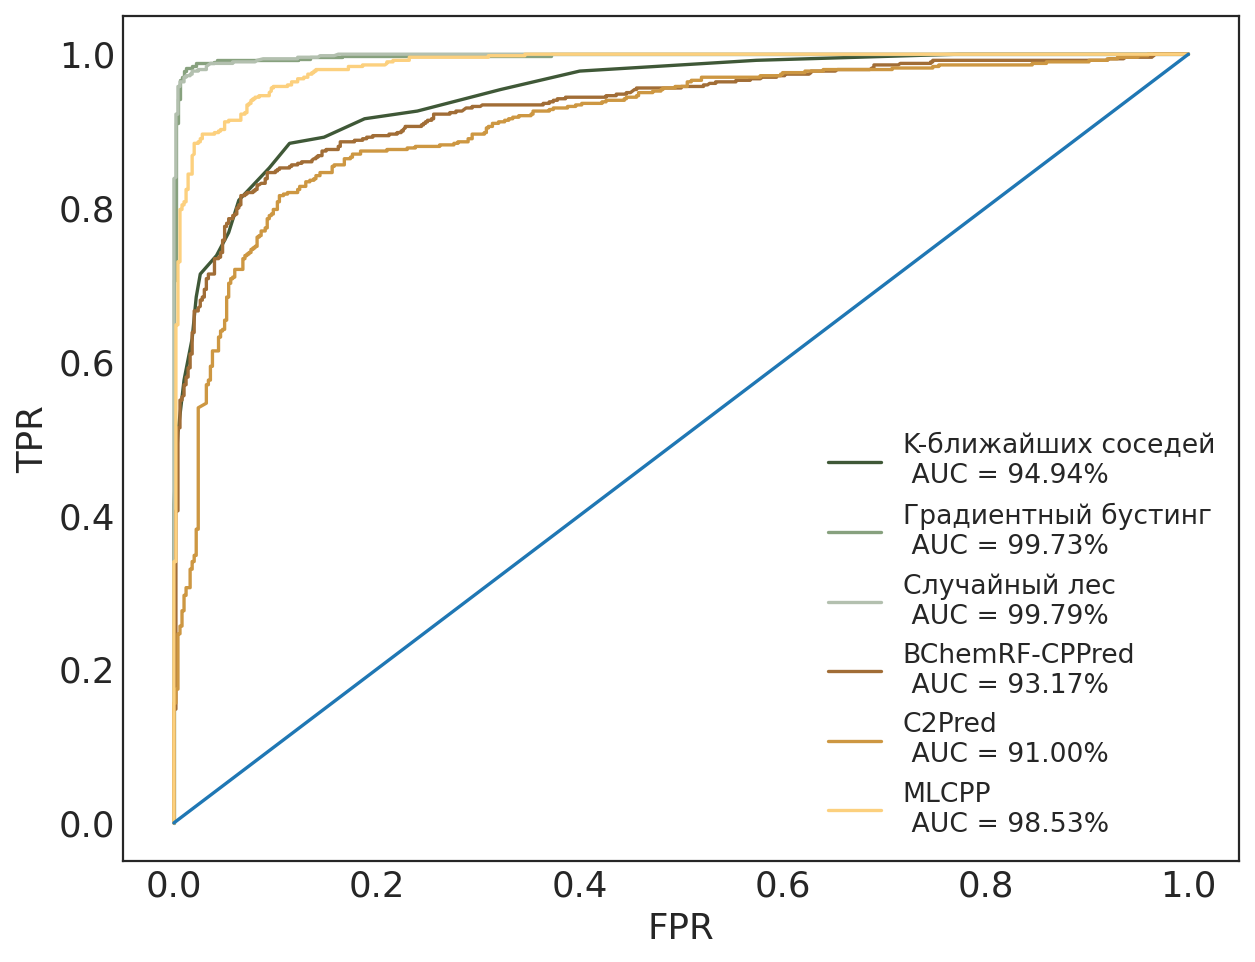

In [ ]:
predicted = [KN_model_final.predict_proba(df_MATCHING)[:, 1], 
             XGB_model_final.predict_proba(df_MATCHING)[:, 1],
             RF_model_final.predict_proba(df_MATCHING)[:, 1],
             pred_CPPred_probability, pred_C2Pred_probability, pred_MLCPP_probability]
plt.figure(figsize=(9,7), dpi= 160)
options = zip(matching_models_name, pd.DataFrame(matching)['ROC AUC'], predicted, palette3)
for name, rocauc, predict, color in options:
    name = name + '\n AUC = ' + rocauc
    plt.plot(*roc_curve(y_matching, predict)[:2], label=name, color = color)
legend_box = plt.legend(fontsize=12, framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
#plt.title('Receiver operating characteristic curve', fontsize=20)
plt.xlabel('FPR', fontsize=16) 
plt.ylabel('TPR', fontsize=16)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()